In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

C:\Users\sunwoong\AppData\Local\Temp\ipykernel_11436\1557460481.py:13: DeprecationWarning: The module "feature_extraction" is deprecated.Please use "dim_reduction" for FPCAor "feature_construction" for feature construction techniques
  from skfda.preprocessing.dim_reduction.feature_extraction import FPCA


In [2]:
data = pd.read_csv('levelups_panel_20240722.csv',encoding='utf-8')
data = data[data['level_to'] <= 100]

In [3]:
focal_data=data[['level_to','player_slug','total_purchase','total_ad','interval','highest_level','binge','first_session_level',
                 'ad_item','ad_revival','purchase','playtime_boss','playtime_dungeon','playtime_tower','playtime_pvp',
                 'playtime_farm','playtime_survival']]

In [4]:
time_points = sorted(focal_data['level_to'].unique())
player_slugs = focal_data['player_slug'].unique()
value_columns=['interval','highest_level','binge','first_session_level',
                 'ad_item','ad_revival','purchase','playtime_boss','playtime_dungeon','playtime_tower','playtime_pvp',
                 'playtime_farm','playtime_survival']

In [5]:
from joblib import Parallel, delayed
data_matrices = {col: np.zeros((len(player_slugs), len(time_points))) for col in value_columns}

def process_player(slug):
    player_data = focal_data[focal_data['player_slug'] == slug]
    player_matrix = {col: np.zeros(len(time_points)) for col in value_columns}
    for j, level in enumerate(time_points):
        if level in player_data['level_to'].values:
            for col in value_columns:
                player_matrix[col][j] = player_data[player_data['level_to'] == level].iloc[0][col]
    return slug, player_matrix

# 병렬 처리
num_cores = 4  # 사용할 CPU 코어 수 설정

# tqdm을 사용하여 진행 상황 표시
results = Parallel(n_jobs=num_cores)(
    delayed(process_player)(slug) for slug in tqdm(player_slugs, desc="Processing players")
)

# 결과를 데이터 매트릭스에 저장
for slug, player_matrix in results:
    i = player_slugs.index(slug)
    for col in value_columns:
        data_matrices[col][i, :] = player_matrix[col]

# 1000단위로 진행 상황 출력
for i in range(len(player_slugs)):
    if (i + 1) % 1000 == 0 or (i + 1) == len(player_slugs):
        print(f"Processed player {i+1}/{len(player_slugs)}")


Processing players: 100%|██████████| 59342/59342 [59:10<00:00, 16.71it/s] 


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [21]:
# 결과를 데이터 매트릭스에 저장
for slug, player_matrix in results:
    i = np.where(player_slugs == slug)[0][0]
    for col in value_columns:
        data_matrices[col][i, :] = player_matrix[col]


In [22]:
# 데이터 매트릭스 확인

# Step 3: 기능 데이터 객체 생성
fd_list = {}
for col, data_matrix in tqdm(data_matrices.items(), desc="Creating FDataGrid objects"):
    fd_list[col] = FDataGrid(data_matrix, time_points)


Creating FDataGrid objects: 100%|██████████| 13/13 [00:00<00:00, 6483.47it/s]


In [23]:
import pickle
with open("fd_list.pkl_2", "wb") as f:
    pickle.dump(fd_list, f)
print("Saved fd_list.pkl")

Saved fd_list.pkl


In [ ]:
# 4. FDataGrid 객체를 pickle 파일에서 불러오기
with open("fd_list.pkl", "rb") as f:
    loaded_fd_list = pickle.load(f)

# 로드된 데이터 확인
for col, fd in loaded_fd_list.items():
    print(f"Data for {col}:")
    print(fd)

KeyboardInterrupt: 

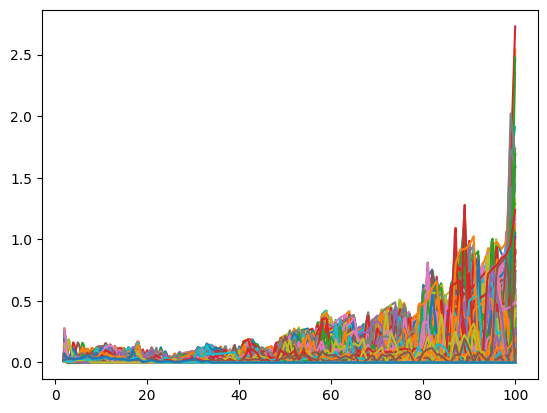

In [25]:
for col, fd in fd_list.items():
    # Step 4: 기능 데이터 시각화
    fd.plot()
    plt.title(f'Functional Data for {col}')
    plt.xlabel('Level to')
    plt.ylabel(col)
    plt.show()

    # Step 5: 데이터 평활화
    basis = FourierBasis(domain_range=(min(time_points), max(time_points)), n_basis=5)
    smoother = BasisSmoother(basis)
    fd_smooth = smoother.fit_transform(fd)

    # 평활화된 데이터 시각화
    fd_smooth.plot()
    plt.title(f'Smoothed Functional Data for {col}')
    plt.xlabel('Level to')
    plt.ylabel(col)
    plt.show()

    # Step 6: PCA 수행
    fpca = FPCA(n_components=3)
    fpca.fit(fd_smooth)
    scores = fpca.transform(fd_smooth)

    # PCA 결과 시각화
    FPCAPlot(fd_smooth, components=[0, 1, 2]).plot()
    plt.title(f'FPCA for {col}')
    plt.show()

    # K-means 클러스터링을 수행합니다.
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(scores)

    # 클러스터 할당
    labels = kmeans.labels_

    # Step 7: 클러스터 시각화 및 해석
    for cluster in np.unique(labels):
        cluster_fd = fd_smooth[labels == cluster]
        cluster_fd.plot()
        plt.title(f'Cluster {cluster + 1} for {col}')
        plt.xlabel('Level to')
        plt.ylabel(col)
        plt.show()
